# 1次元線形移流拡散モデル + EnKF
## 方程式

$$ \frac{\partial C}{\partial t} = -u \frac{\partial C}{\partial x} + \nu \frac{\partial^2 C}{\partial x^2} + w $$

$$ w = \begin{cases} F\sin(\pi x / 60) & (0 \leq x \leq 60) \\ 0 & (x \geq 60) \end{cases} $$

## 実験設定

- 真値

    外力の時間変化を次のように与える

    $$ F_t = \sin(2\pi t/120) + q_t $$

    真値の外力に加える乱数は、時間方向の相関を考慮するためAR(1)過程

    $$ q_t = 0.8 q_{t-1} + 0.2 \mathcal{N}(0,1)$$

    としている。サンプルコードではこの乱数は含まれていない。教科書5.3節(143ページ)の設定では「外力は15ステップ毎に入手するデータとし、ステップ間では線形内挿でを行って与える」とあり、15ステップ程度の時間スケールで乱数成分が時間変動する。

- モデル（フリーラン）

    外力の時間変化を次のように与える

    $$ F_t = \sin(2\pi t/120) $$

In [6]:
from typing import List, Tuple
import torch
import matplotlib.pyplot as plt

In [7]:
import importlib
import main
importlib.reload(main)

<module 'main' from '/Users/ytakano/projects/dass2023/adv/main.py'>

In [11]:
device = torch.device('cpu')

In [17]:
%%time
x_true, x_free, x_filter, std_filter, x_smoother, std_smoother = main.run(device)

CPU times: user 20.3 s, sys: 996 ms, total: 21.3 s
Wall time: 4.17 s


## フリーラン vs 真値
- 誤差(シェード)が下流側に移流している

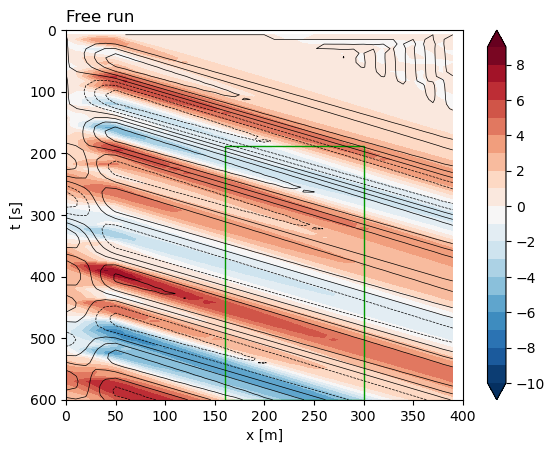

In [18]:
main.plot_xt(
    x_free - x_true, 
    torch.arange(-10, 10, 1),
    "RdBu_r",
    x_free, 
    torch.arange(-20, 20, 5),
    "Free run",
)

## EnKF vs 真値
- メンバ数100
- 同化領域(緑枠)の下流側で誤差が減少している
- 観測誤差はσ=8で、下流側の誤差の大きさはそれより小さい（4未満)
- 同化された下流側はスプレッドが2程度に減少

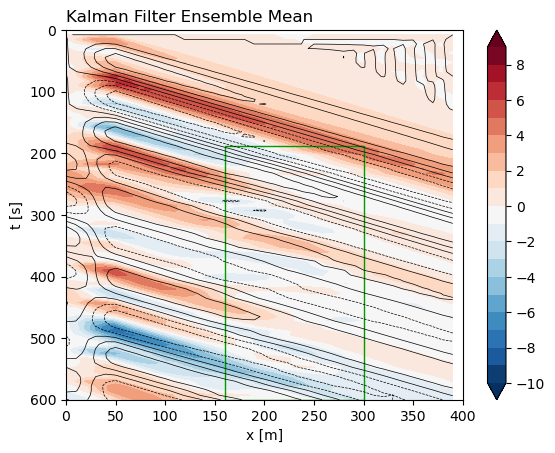

In [19]:
main.plot_xt(
    x_filter - x_true, 
    torch.arange(-10, 10, 1),
    "RdBu_r",
    x_filter,
    torch.arange(-20, 20, 5),
    "Kalman Filter Ensemble Mean"
)

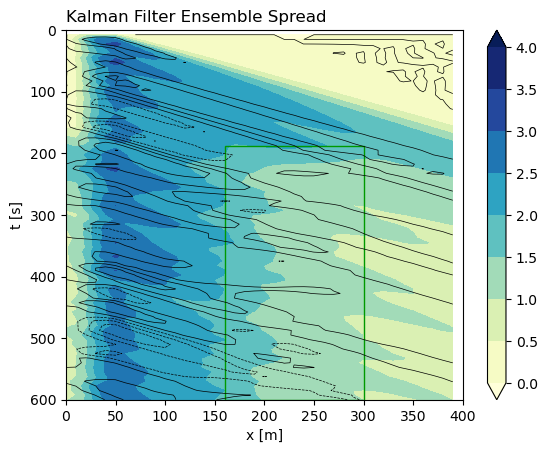

In [20]:
main.plot_xt(
    std_filter, 
    torch.arange(0, 4.1, 0.5),
    "YlGnBu",
    x_filter - x_true,
    torch.arange(-10, 10, 2),
    "Kalman Filter Ensemble Spread"
)

## 固定ラグ平滑化 vs 真値
- メンバ数100、ラグ300ステップ(150秒)
- 場が滑らかになった
- EnKFと比べて上流側の誤差も減少している
- 上流側のアンサンブルスプレッドも減少

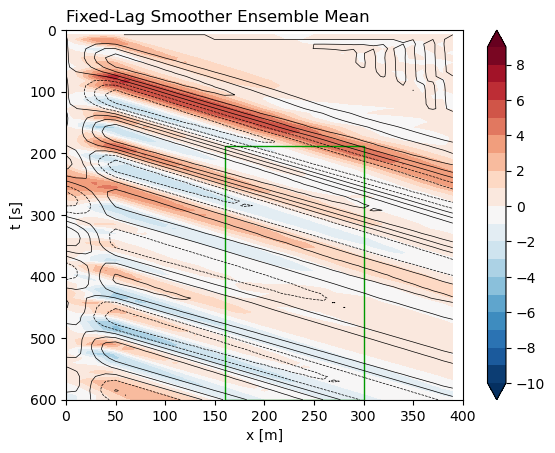

In [21]:
main.plot_xt(
    x_smoother - x_true, 
    torch.arange(-10, 10, 1),
    "RdBu_r",
    x_smoother,
    torch.arange(-20, 20, 5),
    "Fixed-Lag Smoother Ensemble Mean",
)

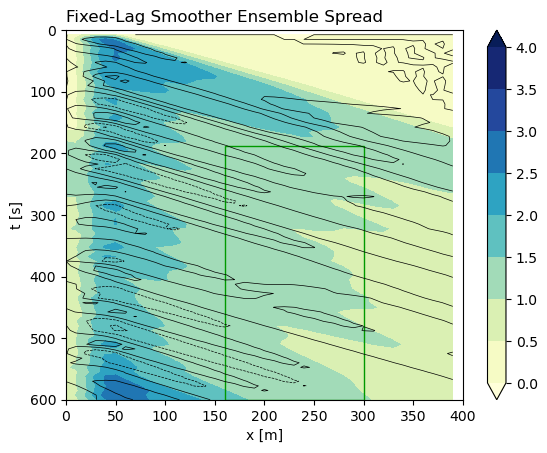

In [22]:
main.plot_xt(
    std_smoother, 
    torch.arange(0, 4.1, 0.5),
    "YlGnBu",
    x_smoother - x_true,
    torch.arange(-10, 10, 2),
    "Fixed-Lag Smoother Ensemble Spread"
)